In [29]:
# This code block imports all the libraries we need, saves all the functions, and
# reads data from CSV and prepares it for analysis

# IMPORT NECESSARY LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize


## FUNCTIONS WE HAVE WRITTEN
# Simulate the SIR model if we know alpha, beta, S0, I0, R0
def sirBasic(S0, I0, R0, alpha, beta, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i], beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i], alpha*SIR[1,i]])

    return SIR

# Advanced SIR Model
# alpha1 transitions to alpha2 according to a sigmoid curve
# (center of transition at time n1 and k1 controls how fast it transitions)
# beta1 transitions to beta2 according to a sigmoid curve
# (center of transition at time m1 and j1 controls how fast it transitions)

# Sigmoid function
def sigmoid(t):
    return 1/(1+np.exp(-t))

# Advanced SIR simulation
def sirAdvanced(S0, I0, R0, alpha1, alpha2, beta1, beta2, n1, m1, k, j, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        # update alpha
        alpha = (alpha2 - alpha1)*sigmoid(k*(i - n1)) + alpha1

        # update beta
        beta = (beta2 - beta1)*sigmoid(j*(i - m1)) + beta1

        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i], beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i], alpha*SIR[1,i]])

    return SIR

# Function that computes the error between simulated data and real data
def findError(data, simulated):
    return math.sqrt(np.sum((data - simulated)**2))

# Gradient descent method that minimizes a function of one variable
def gradientDescent1D(f, x0, h, tolerance, maxIterations):
    x = x0
    step = h

    for counter in range(maxIterations+1):
        slope = (f(x+step) - f(x))/step
        step = -slope*h
        x = x + step

        if x < 0:
            x = -1*x

        if math.fabs(slope) < tolerance:
            print('1D gradient descent took', counter, 'iterations to converge')
            print('The slope at', x, 'is approximately', slope)
            return x
            break

        if counter == maxIterations:
            print('1D gradient descent failed')
            print('The slope at', x, 'is approximately', slope)
            return x

## DATA PREPARATION AND READING FROM CSV
# Read real data from a CSV file and run the basic SIR model (skip row 1, ignore column 0)

data = np.genfromtxt('COVID19DataSK.csv', delimiter=',', skip_header = 1, usecols = (1, 2, 3, 4))
#data = np.genfromtxt('COVID19DataUSlimited.csv', delimiter=',', skip_header = 1, usecols = (1, 2, 3, 4))
#data = np.genfromtxt('Covid19DataUSLimitedEditedRecovery.csv', delimiter=',', skip_header = 1, usecols = (1, 2, 3, 4))

# Turn the columns into rows
data = np.transpose(data)

# Find the number of days in the real data
lastDay = int(data[0,-1])

# Delete the "day" row in the real data so it will have S, I, and R rows like our SIR models
data = data[1:4,:]

# Pull initial data values from the real data
S0 = data[0,0]
I0 = data[1,0]
R0 = data[2,0]

In [30]:
# this is ERR(alpha,b)
# Basic Model
# x = [x[0], x[1]] = (alpha, b)
#f = lambda x: findError(sirBasic(S0,I0,R0,x[0],x[1]/S0,lastDay), data)

# Advanced Model
# x = [x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]] = (alpha1, alpha2, beta1, beta2, n1, m1, k, j)
f = lambda x: findError(sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],lastDay), data)

# Run the optimization code (multidimensional gradient descent) to find the best parameters for ths model
# to fit to the data. (This solves for *all* parameters at one time!)

#result = optimize.minimize(f, [0.1, 0.2], bounds = ((0,1), (0,1)))
result = optimize.minimize(f, [0.1, 0.2, 0.3, 0.5, lastDay/2, lastDay/2, 1, 1],
                           bounds=((0,1),(0,1),(0,1),(0,1),(0,lastDay),(0,lastDay),(-10,10),(-10,10)))

print(result)

x = result.x

      fun: 1082.0363861443836
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.95171218e+00, -3.04787591e+00, -3.08318704e-01, -5.52081474e+00,
        2.54658516e-02, -1.65982783e-03,  3.18732418e-01,  1.59388946e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3465
      nit: 298
   status: 0
  success: True
        x: array([ 5.88031122e-02,  2.22153311e-03,  6.54008712e-01,  2.53392829e-02,
        2.68305132e+01,  1.09644948e+01, -3.12628104e-01,  3.57817060e-01])


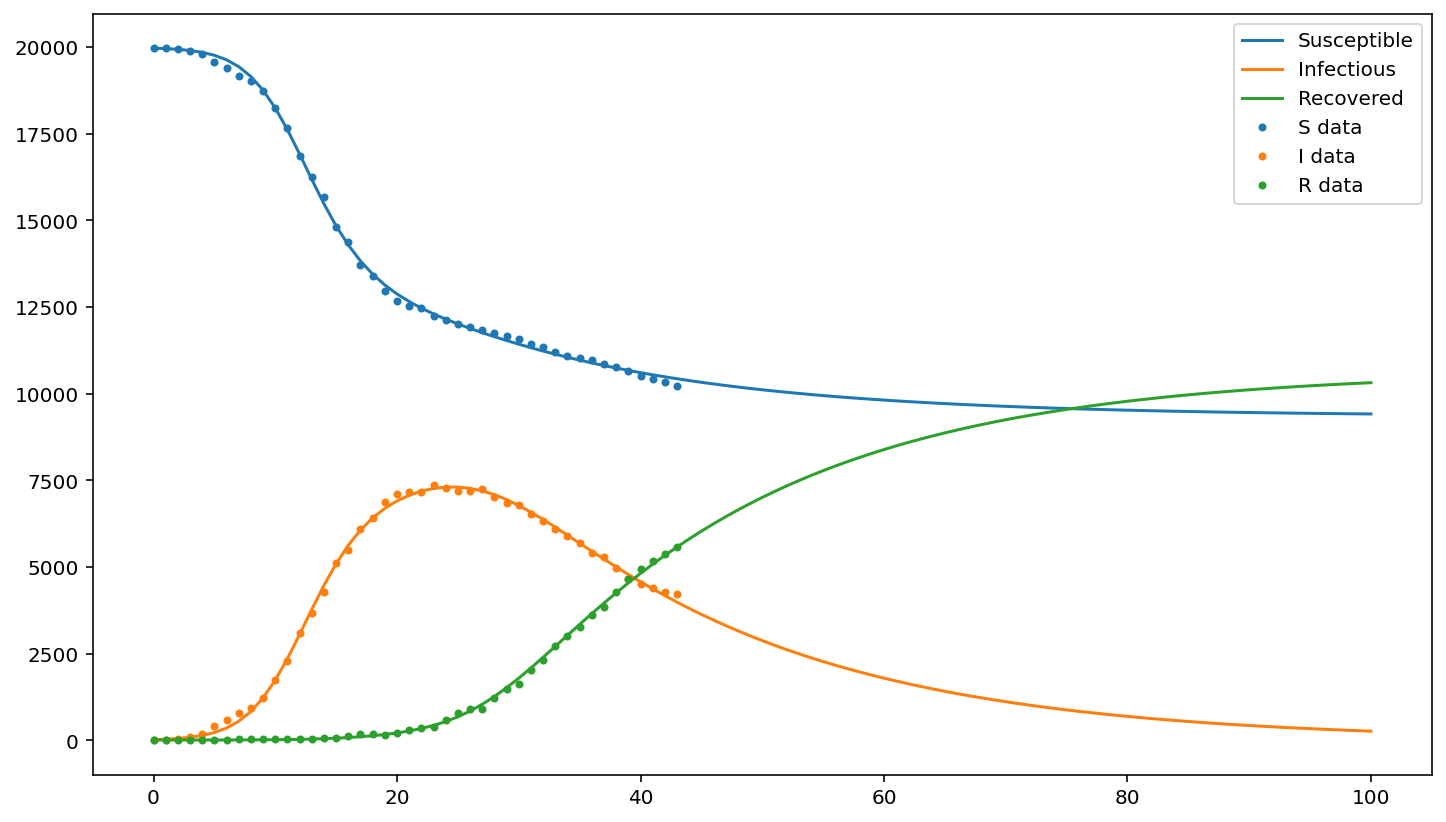

In [31]:
n = 100
#simulated = sirBasic(S0,I0,R0,x[0],x[1]/S0,n)
simulated = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

# Plot the simulated data as curves
plt.plot(simulated[0,:], label='Susceptible')
plt.plot(simulated[1,:], label='Infectious')
plt.plot(simulated[2,:], label='Recovered')

# Reset the colors
plt.gca().set_prop_cycle(None)

# Plot the real data as dots
plt.plot(data[0,:], '.', label='S data')
plt.plot(data[1,:], '.', label='I data')
plt.plot(data[2,:], '.', label='R data')

plt.legend()

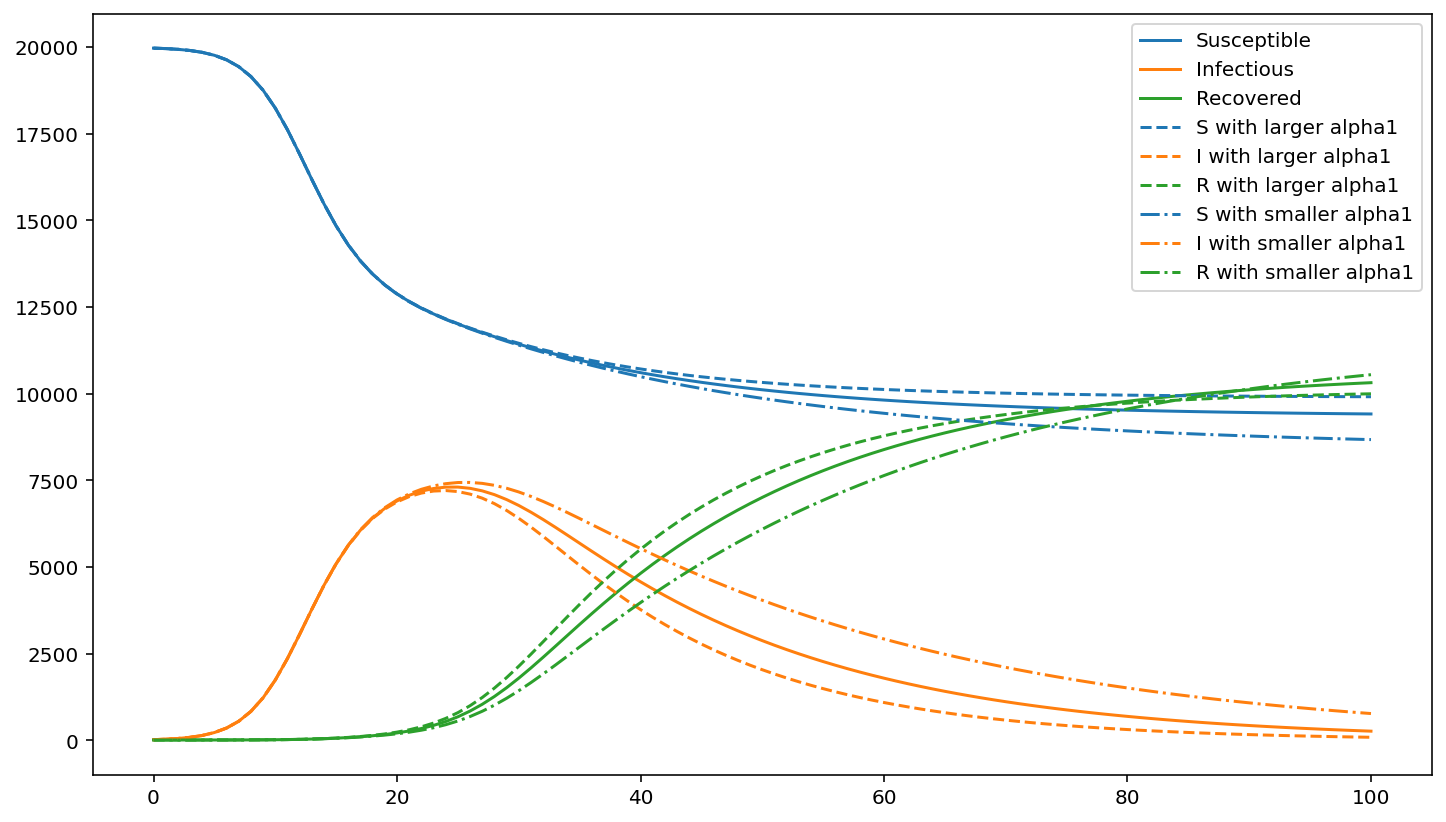

In [7]:
#simulated = sirBasic(S0,I0,R0,x[0],x[1]/S0,lastDay)
# Brianna: x[1]
# Raghav: x[2]
# Ryan: x[3]
# Sean: x[4]
# Tiffany: x[5]

n = 100
simulated = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

# Plot the optimal model
plt.plot(simulated[0,:], label='Susceptible')
plt.plot(simulated[1,:], label='Infectious')
plt.plot(simulated[2,:], label='Recovered')

# Reset the colors
plt.gca().set_prop_cycle(None)

percentChange = 0.25

simulatedDataWithChangeInAlpha1 = sirAdvanced(S0,I0,R0,(1+percentChange)*x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

# Plot the model with 125% alpha1
plt.plot(simulatedDataWithChangeInAlpha1[0,:], '--', label='S with larger alpha1')
plt.plot(simulatedDataWithChangeInAlpha1[1,:], '--', label='I with larger alpha1')
plt.plot(simulatedDataWithChangeInAlpha1[2,:], '--', label='R with larger alpha1')

# Reset the colors
plt.gca().set_prop_cycle(None)

simulatedDataWithChangeInAlpha1 = sirAdvanced(S0,I0,R0,(1-percentChange)*x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

# Plot the model with 75% alpha1
plt.plot(simulatedDataWithChangeInAlpha1[0,:], '-.', label='S with smaller alpha1')
plt.plot(simulatedDataWithChangeInAlpha1[1,:], '-.', label='I with smaller alpha1')
plt.plot(simulatedDataWithChangeInAlpha1[2,:], '-.', label='R with smaller alpha1')

plt.legend()

Text(0, 0.5, 'Cases')

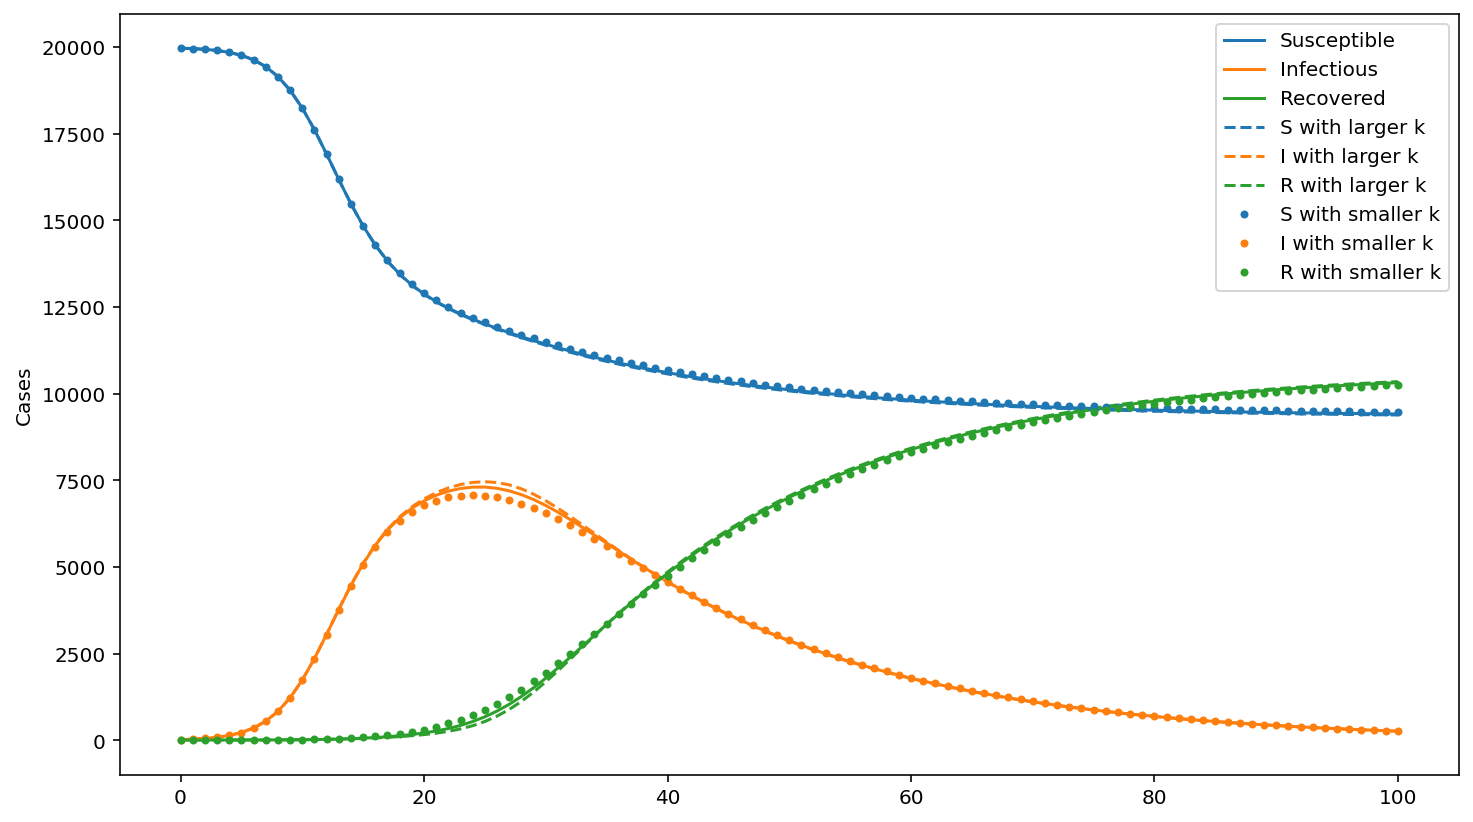

In [12]:
n = 100
simulated = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

percentChange = 0.25

# Plot the simulated data as curves
plt.plot(simulated[0,:], label='Susceptible')
plt.plot(simulated[1,:], label='Infectious')
plt.plot(simulated[2,:], label='Recovered')

# Reset the colors
plt.gca().set_prop_cycle(None)

simulatedDataWithChangeInAlpha1 = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],(1+percentChange)*x[6],x[7],n)

# Plot the real data as dots
plt.plot(simulatedDataWithChangeInAlpha1[0,:], '--', label='S with larger k')
plt.plot(simulatedDataWithChangeInAlpha1[1,:], '--', label='I with larger k')
plt.plot(simulatedDataWithChangeInAlpha1[2,:], '--', label='R with larger k')

# Reset the colors
plt.gca().set_prop_cycle(None)

simulatedDataWithChangeInAlpha1 = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],(1-percentChange)*x[6],x[7],n)

# Plot the real data as dots
plt.plot(simulatedDataWithChangeInAlpha1[0,:], '.', label='S with smaller k')
plt.plot(simulatedDataWithChangeInAlpha1[1,:], '.', label='I with smaller k')
plt.plot(simulatedDataWithChangeInAlpha1[2,:], '.', label='R with smaller k')

plt.legend()
plt.ylabel('Cases')

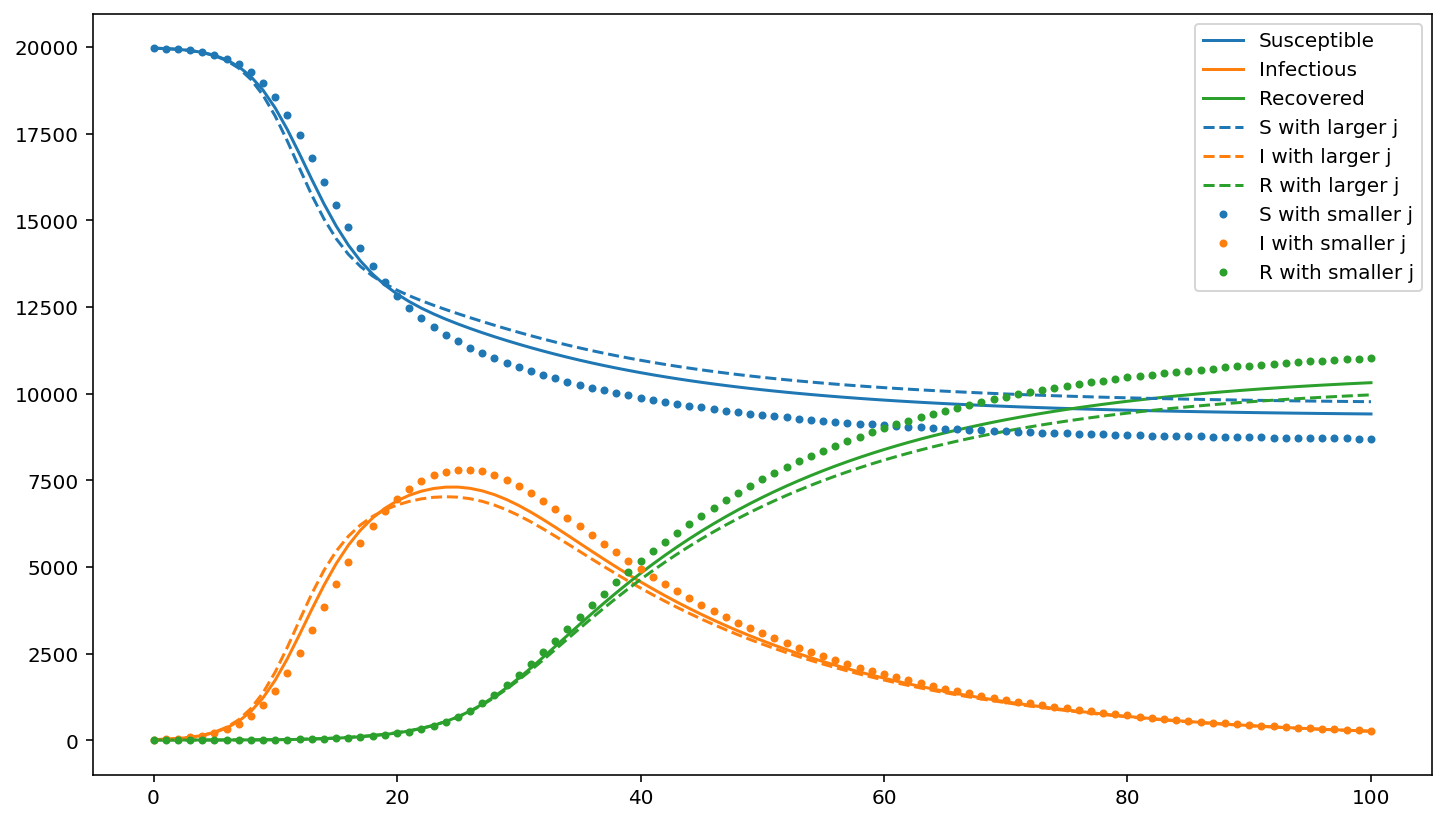

In [11]:
n = 100
simulated = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

percentChange = 0.25

# Plot the simulated data as curves
plt.plot(simulated[0,:], label='Susceptible')
plt.plot(simulated[1,:], label='Infectious')
plt.plot(simulated[2,:], label='Recovered')

# Reset the colors
plt.gca().set_prop_cycle(None)

simulatedDataWithChangeInAlpha1 = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],(1+percentChange)*x[7],n)

# Plot the real data as dots
plt.plot(simulatedDataWithChangeInAlpha1[0,:], '--', label='S with larger j')
plt.plot(simulatedDataWithChangeInAlpha1[1,:], '--', label='I with larger j')
plt.plot(simulatedDataWithChangeInAlpha1[2,:], '--', label='R with larger j')

# Reset the colors
plt.gca().set_prop_cycle(None)

simulatedDataWithChangeInAlpha1 = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],(1-percentChange)*x[7],n)

# Plot the real data as dots
plt.plot(simulatedDataWithChangeInAlpha1[0,:], '.', label='S with smaller j')
plt.plot(simulatedDataWithChangeInAlpha1[1,:], '.', label='I with smaller j')
plt.plot(simulatedDataWithChangeInAlpha1[2,:], '.', label='R with smaller j')

plt.legend()

In [2]:
# this is ERR(alpha,b)
# Basic Model
# x = [x[0], x[1]] = (alpha, b)
#f = lambda x: findError(sirBasic(S0,I0,R0,x[0],x[1]/S0,lastDay), data)

# Advanced Model
# x = [x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]] = (alpha1, alpha2, beta1, beta2, n1, m1, k, j)
f = lambda x: findError(sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],lastDay), data)

# Run the optimization code (multidimensional gradient descent) to find the best parameters for ths model
# to fit to the data. (This solves for *all* parameters at one time!)

#result = optimize.minimize(f, [0.1, 0.2], bounds = ((0,1), (0,1)))
result = optimize.minimize(f, [0.1, 0.2, 0.3, 0.5, lastDay/2, lastDay/2, 1, 1],
                           bounds=((0,1),(0,1),(0,1),(0,1),(0,lastDay),(0,lastDay),(-10,10),(-10,10)))

print(result)

x = result.x

      fun: 1082.0363861443836
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.95171218e+00, -3.04787591e+00, -3.08318704e-01, -5.52081474e+00,
        2.54658516e-02, -1.65982783e-03,  3.18732418e-01,  1.59388946e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3465
      nit: 298
   status: 0
  success: True
        x: array([ 5.88031122e-02,  2.22153311e-03,  6.54008712e-01,  2.53392829e-02,
        2.68305132e+01,  1.09644948e+01, -3.12628104e-01,  3.57817060e-01])
